# QITE TRY

In [44]:
import numpy as np
import scipy
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter

In [ ]:
def cost_func(coeffs_list, pauli_list, H, tau, initial_state):
    A = SparsePauliOp(pauli_list, coeffs_list).to_matrix()
    U = scipy.linalg.expm(-1j*A*tau)
    C = U - np.eye(2**N) + 1j*A

    phi = np.matmul(C, initial_state)
    
    return np.linalg.norm(phi)

In [ ]:
# SciPy minimizer routine
N = 2
pauli_list = get_pauli_list(N)
coeffs_list = np.ones(4**N)
tau = 0.01
initial_state = np.array([0.5, 0.5, 0.5, 0.5])
H = SparsePauliOp(["II"], coeffs=[1.0]).to_matrix()

result = minimize(cost_func, coeffs_list, args=(pauli_list, H, tau, initial_state), method="SLSQP")

result

In [ ]:
tau = 0.0001
initial_state_0 = np.array([1, 1, 1, 1], dtype=complex)
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["II"], coeffs=[1.0]).to_matrix()
c = 1. - 2*tau*np.matmul(np.conjugate(initial_state).T, np.matmul(H, initial_state))
S = np.zeros([len(pauli_list), len(pauli_list)], dtype=complex)
b = np.zeros(len(pauli_list), dtype=complex)

for i in range(len(pauli_list)):
    sx_pauli = SparsePauliOp(pauli_list[i], 1.0).to_matrix()
    sx = np.matmul(np.conjugate(initial_state).T, np.conjugate(sx_pauli).T)
    dx_b = np.matmul(H, initial_state)
    b[i] = (-1.j/np.sqrt(c))*np.matmul(sx, dx_b)
    for j in range(len(pauli_list)):
        dx_pauli = SparsePauliOp(pauli_list[j], 1.0).to_matrix()
        dx_S = np.matmul(dx_pauli, initial_state)
        
        S[i,j] = np.matmul(sx, dx_S)

In [ ]:
def get_pauli_list(N):
    basis = ["I", "X", "Y", "Z"]
    pauli_list = []
    for i in range(len(basis)):
        for j in range(len(basis)):
            pauli_list.append(basis[i]+basis[j])
            
    return pauli_list



def get_coeffs_list_algebra(H, initial_state, tau=0.001, N = 2):
    pauli_list = get_pauli_list(N)
    c = 1. - 2*tau*np.matmul(np.conjugate(initial_state).T, np.matmul(H, initial_state))
    S = np.zeros([len(pauli_list), len(pauli_list)], dtype=complex)
    b = np.zeros(len(pauli_list), dtype=complex)
    
    for i in range(len(pauli_list)):
        sx_pauli = SparsePauliOp(pauli_list[i], 1.0).to_matrix()
        sx = np.matmul(np.conjugate(initial_state).T, np.conjugate(sx_pauli).T)
        dx_b = np.matmul(H, initial_state)
        b[i] = (-1.j/np.sqrt(c))*np.matmul(sx, dx_b)
        for j in range(len(pauli_list)):
            dx_pauli = SparsePauliOp(pauli_list[j], 1.0).to_matrix()
            dx_S = np.matmul(dx_pauli, initial_state)

            S[i,j] = np.matmul(sx, dx_S)
            
    #print(S)
    #print(b)
    return np.matmul(np.linalg.pinv(S), b)



def qite_step_algebra(H, initial_state, tau=0.001, N=2):
    pauli_list = get_pauli_list(N)
    coeffs_list = get_coeffs_list_algebra(H, initial_state, tau, N)
    #print(SparsePauliOp(pauli_list, coeffs_list))
    A = SparsePauliOp(pauli_list, coeffs_list).to_matrix()
    
    final_state = np.matmul(scipy.linalg.expm(-1j*A*tau), initial_state)
    return final_state

In [ ]:
tau = 0.001
initial_state_0 = np.array([1., 0., 0., 0.])
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["XI"], coeffs=[1.0]).to_matrix()


# TEST FOR SINGLE QITE STEP

phi_A = qite_step_algebra(H, initial_state, tau)
phi_H = np.matmul(scipy.linalg.expm(-H*tau), initial_state)/np.sqrt(np.matmul(np.conjugate(initial_state).T, np.matmul(scipy.linalg.expm(-2*H*tau), initial_state)))

print("phi_A = ", phi_A)
print("||phi_A|| = ", np.linalg.norm(phi_A))
print("")
print("phi_H = ", phi_H)
print("")
print("Overlap =", np.matmul(np.conjugate(phi_A).T,phi_H))

In [ ]:
tau = 0.01
beta = 1.5
n = beta/tau
initial_state_0 = np.array([1., 0., 0., 0.], dtype=complex)
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["XI"], coeffs=[1.0]).to_matrix()

state_list = [initial_state]
for i in range(int(n)-1):
    state_list.append(qite_step_algebra(H, state_list[-1], tau))

In [ ]:
#TEST FOR QITE PRINCIPLE
c = np.absolute(np.matmul(np.conjugate(initial_state).T, np.matmul(scipy.linalg.expm(-2*H*beta), initial_state)))
print(c)
phi_H = np.matmul(scipy.linalg.expm(-H*beta), initial_state)/np.sqrt(c)
print(np.linalg.norm(phi_H))
print(np.linalg.norm(state_list[-1]))

print("phi_A = ", state_list[-1]/np.linalg.norm(state_list[-1]))
print("")
print("phi_H = ", phi_H)
print("")
print("Overlap_A =", np.absolute(np.matmul(np.conjugate(state_list[-1]).T,exact_ground_state)))
print("")
print("Overlap_B =", np.absolute(np.matmul(np.conjugate(phi_H).T, exact_ground_state)))

In [ ]:
import matplotlib.pyplot as plt

exact_ground_state = np.array([1./np.sqrt(2), 0, 0, -1./np.sqrt(2)])
x = range(int(n))
y1 = []
y2 = []
for i in range(len(state_list)):
    y1.append(np.absolute(np.matmul(np.conjugate(state_list[i]).T, exact_ground_state)))
    y2.append(np.absolute(np.matmul(np.conjugate(phi_H).T, exact_ground_state)))
    
plt.plot(x, y1)
plt.plot(x, y2)

In [ ]:
### QUANTUM CIRCUIT IMPLEMENTATION

In [ ]:
import numpy as np
import scipy
from scipy.linalg import expm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import Sampler, Estimator


def exp_value(circuit, observable, estimator=Estimator()):
    job = estimator.run(circuit, observable)
    
    return job.result().values[0]



def get_pauli_list(N=2):
    basis = ["I", "X", "Y", "Z"]
    pauli_list = []
    for i in range(len(basis)):
        for j in range(len(basis)):
            pauli_list.append(basis[i]+basis[j])
            
    return pauli_list



def get_coeffs_list(H, initial_circuit, tau=0.001, N = 2):
    pauli_list = get_pauli_list(N)
    c = 1. - 2.*tau*exp_value(initial_circuit, H)
    #print(c)
    S = np.ones([len(pauli_list), len(pauli_list)], dtype=complex)
    b = np.zeros(len(pauli_list), dtype=complex)
    
    for k in range(len(pauli_list)):
        b[k] = (0-1j/np.sqrt(c))*exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(H)))
        for l in range(len(pauli_list)):
            #S[k,l] = np.around(exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(SparsePauliOp([pauli_list[l]])))))
            S[k,l] = exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(SparsePauliOp([pauli_list[l]]))))

    #print(S)
    #print(b)
    return np.linalg.solve(S+S.T, -b)



def qite_step(H, circuit, tau=0.001, N=2):
    pauli_list = get_pauli_list(N)
    coeffs_list = get_coeffs_list(H, circuit, tau, N)
    A = SparsePauliOp(pauli_list, coeffs_list)
    print(A)
    print(A.adjoint().to_matrix())
    
    U = Operator(expm(0.-1.j*A.to_matrix()*tau))
    print(U.is_unitary())
    
    #circuit.append(U, [0,1])
    return U

# VarQITE Implementation on LMG

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

def twolocal(n, gates=["ry"], entanglement="linear", reps=1, par_name="x", par = None):
    
    
    def lin_entanglement(qc):
        n = qc.num_qubits
        for qubit in range(0, n-1):
            qc.cx(qubit, qubit+1)
            
    def single_rep(qc, gates, par):
        n = qc.num_qubits
        for i in range(0, n):
            for gate in gates:
                if gate == "ry":
                    qc.ry(par[i], i)

    #if par == None:
    #    par = [Parameter("{}_{}".format(par_name,i)) for i in range(0,n*len(gates)*(reps+1))]
    qc = QuantumCircuit(n)

    
    single_rep(qc, gates, par[:(n*len(gates))])
    
    for rep in range(1, reps+1):
        if entanglement == "linear":
            lin_entanglement(qc)
        single_rep(qc, gates, par[n*len(gates)*(rep):n*len(gates)*(rep+1)])

    return qc

In [3]:
import numpy as np
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, VarQITE
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal


N = 2
B = 0.7
gy = 0.8
ansatz = TwoLocal(N, "ry", "cx", entanglement="linear", reps=2)
phi_list = [Parameter('phi_{}'.format(i)) for i in range(ansatz.num_parameters)]
for i in range(len(phi_list)):
    phi_list[i] = 2*np.pi*np.random.uniform()
#phi_list[2] = np.pi/2-0.7
#phi_list[3] = np.pi+0.9
H = SparsePauliOp(["XX", "YY", "IZ", "ZI"], [-1./N, -gy/N, -B, -B])
beta = 5

problem = TimeEvolutionProblem(H, beta)


qite = VarQITE(ansatz, phi_list)
result = qite.evolve(problem)

In [7]:
print(result)

{   'aux_ops_evaluated': None,
    'evolved_state': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001E3F3338050>,
    'observables': [],
    'parameter_values': array([[2.27209671, 3.19175246, 1.96312537, 5.17560164, 3.33199841,
        0.96082062],
       [2.27258292, 3.18642903, 1.96213346, 5.17829625, 3.33641337,
        0.9632598 ],
       [2.27307317, 3.18121193, 1.96112518, 5.18091032, 3.34076265,
        0.96566156],
       ...,
       [2.7996454 , 3.11887593, 1.26887238, 4.77321789, 4.1062994 ,
        1.60755293],
       [2.80032364, 3.11896746, 1.26811189, 4.77287142, 4.10703981,
        1.60824437],
       [2.80099918, 3.11905827, 1.26735481, 4.77252728, 4.10777698,
        1.60893279]]),
    'times': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.

Ansatz used


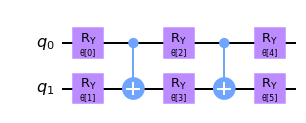

Initial circuit


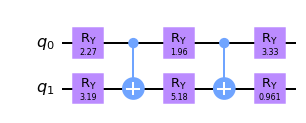

Final circuit


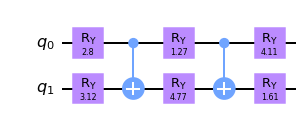

In [11]:
print("Ansatz used")
display(ansatz.decompose().draw("mpl"))
print("Initial circuit")
display(twolocal(n=N, gates=["ry"], reps=2, par = result.parameter_values[0]).draw("mpl"))
print("Final circuit")
display(result.evolved_state.decompose().draw("mpl"))

In [12]:
initial_state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, gates = ["ry"], reps=2, par = result.parameter_values[0]))
final_state = Statevector([1.,0.,0.,0.]).evolve(result.evolved_state)

print(initial_state)
print(final_state)

Statevector([-0.32213049+0.j,  0.71167802+0.j,  0.56989172+0.j,
             -0.25489169+0.j],
            dims=(2, 2))
Statevector([-0.97613852+0.j,  0.15156233+0.j,  0.15155582+0.j,
             -0.03483225+0.j],
            dims=(2, 2))


In [13]:
from qiskit.quantum_info import Operator
from qiskit.opflow import X, Y, Z, I
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np


def ClassicalLMGH(Natoms, gy, B):  # Spin_Magnet_Hamilton_class
    """
    Returns the hamiltonian operator of LMG model given its parameters.

        Parameters:
                Natoms(int): number of qubits considered
                B(float): Magnetic field intensity
                gy(float): parameter of hamiltonian

        Returns:
                Hamiltonian(operator): Operator of the hamiltonian
    """

    # initialize 0-dimensional Operators
    field = Operator([0])
    spin = Operator([0])

    # cycle over all qubits
    for i in range(Natoms):

        # Adds the spin field interaction for each atom
        field = field ^ I
        field -= B * ((I ^ i) ^ Z)

        # Adds a qubit to the spin part
        spin = spin ^ I

        # implementation for the i-th qubit
        # of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= 1 / Natoms * ((I ^ j) ^ X ^ (I ^ (i - j - 1)) ^ X)
            spin -= 1 / Natoms * gy * ((I ^ j) ^ Y ^ (I ^ (i - j - 1)) ^ Y)
    return spin + field



def ClassicalDiagonalizer(H):  # class_par_H_diagonalizer
    """
    Diagonalizer of parametrized H.

        Parameters:
                H(list of matrices): The matrices to be diagonalizedt, the matrices must be Hermitian
        Returns:
                EigenValues: list containing Eigenvalues
                EigenStates: list containing Eigenstates
                MinEigenValues: list containing "Ground state" value
                MinEigenStates:    list cointaining "Ground state"
                ExecTime: list containing the time it took to diagonalize the matrix
    """
    EigenValues = [[] * 2 ** (H[0].num_qubits) for _ in range(len(H))]
    EigenStates = [[] * 2 ** (H[0].num_qubits) for _ in range(len(H))]
    MinEigenState = []
    MinEigenValue = []
    ExecTime = []
    for i in range(len(H)):
        start = time.time()
        # Classical diagonalizer for Hermitian matrix. Eig vals are sorted automatically
        w, v = np.linalg.eigh(H[i])
        for j in range(len(w)):
            EigenValues[i].append(w[j])
            EigenStates[i].append(v[:, j])
        MinEigenValue.append(w[0])
        MinEigenState.append(v[:, 0])
        ExecTime.append(time.time() - start)
    return EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime

In [17]:
H_exact = [ClassicalLMGH(N, gy, B)]
EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime = ClassicalDiagonalizer(H_exact)
print("Numerical obtained eigenstate = ", MinEigenState)
print("")
print("VarQITE obtained eigenstate = ", final_state)
print("")
print("Numerical obtained eigenvalue =", MinEigenValue)
print("")
print("VarQITE obtained eigenvalue = ", final_state.expectation_value(H))

Numerical obtained eigenstate =  [array([-0.99936447+0.j,  0.        +0.j,  0.        +0.j, -0.03564618+0.j])]

VarQITE obtained eigenstate =  Statevector([-0.97613852+0.j,  0.15156233+0.j,  0.15155582+0.j,
             -0.03483225+0.j],
            dims=(2, 2))

Numerical obtained eigenvalue = [-1.40356688476182]

VarQITE obtained eigenvalue =  (-1.380432865914496+0j)


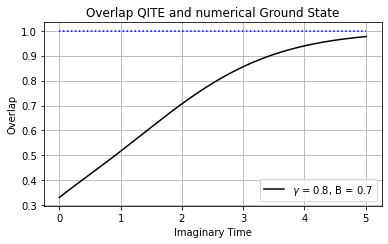

In [15]:
initial_state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, gates = ["ry"], reps=2, par = result.parameter_values[0]))
exact_ground_state = Statevector(MinEigenState[0])
x = result.times
y1 = []
y2 = []

for i in range(len(x)):
    #qc = QuantumCircuit(2)
    #qc.append(twolocal(n=2, gates = ["ry"], reps=2, par = result.parameter_values[i]), [0,1])
    state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, reps=2, par = result.parameter_values[i]))
    y1.append(np.absolute(state.inner(exact_ground_state)))
    y2.append(1.)

plt.rcParams["figure.figsize"] = [5.50, 3.50]
plt.rcParams["figure.autolayout"] = True

    
gylabel = "$\gamma$ = {gy:.1f}, B = {B:.1f}"

plt.title("Overlap QITE and numerical Ground State")


plt.plot(x, y1, color="black", label=gylabel.format(gy=gy,B=B))
plt.plot(x, y2, color="blue", ls="dotted")

plt.ylabel('Overlap')
plt.xlabel('Imaginary Time')


# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()

# QMETTS Algorithm

In [29]:
EigenStates[0]

[array([-0.99936447+0.j,  0.        +0.j,  0.        +0.j, -0.03564618+0.j]),
 array([-0.        +0.j, -0.70710678+0.j, -0.70710678+0.j,  0.        +0.j]),
 array([ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.        +0.j]),
 array([-0.03564618+0.j,  0.        +0.j,  0.        +0.j,  0.99936447+0.j])]

In [100]:
N =2
beta = 0.001

Z = 0
rho = np.zeros([2**N, 2**N], dtype=complex)
for i in range(len(EigenValues[0])):
    Z += np.exp(- beta*EigenValues[0][i])
    rho += np.exp(- beta*EigenValues[0][i])*np.matmul(np.atleast_2d(EigenStates[0][i]).T,np.atleast_2d(EigenStates[0][i]))
rho = rho/Z
rho
exact_average = np.trace(np.matmul(H_exact[0].to_matrix(), rho))
exact_average

(-0.00138999941203366+0j)

In [115]:
from qiskit.primitives import Estimator


def exp_value(circuit, observable, estimator=Estimator()):
    job = estimator.run(circuit, observable)
    
    return job.result().values[0]

def QITE(H, parameter_list, ansatz, tau):
    
    problem = TimeEvolutionProblem(H, beta)
    qite = VarQITE(ansatz, parameter_list)
    result = qite.evolve(problem)
    
    return result

def state_to_par(label = "++", num_params = 6):
    
    par_list = np.zeros(num_params)
    if label == "++":
        par_list[-2] = np.pi
        par_list[-1] = np.pi
    elif label == "+-":
        par_list[-2] = np.pi
        par_list[-1] = 3*np.pi    
    elif label == "-+":
        par_list[-2] = 3*np.pi
        par_list[-1] = np.pi
    elif label == "--":
        par_list[-2] = 3*np.pi
        par_list[-1] = 3*np.pi

    return par_list

In [113]:
N = 2
B = 0.7
gy = 0.8
tau = beta/2.

ansatz = TwoLocal(N, "ry", "cx", entanglement="linear", reps=2)
parameter_list = [Parameter('phi_{}'.format(i)) for i in range(ansatz.num_parameters)]
for i in range(len(parameter_list)):
    parameter_list[i] = 2*np.pi*np.random.uniform()
    
H = SparsePauliOp(["XX", "YY", "IZ", "ZI"], [-1./N, -gy/N, -B, -B])

result = QITE(H, parameter_list, ansatz, tau)
final_state = Statevector([1.,0.,0.,0.]).evolve(result.evolved_state)

measure = exp_value(result.evolved_state, H)

print("final_state = ", final_state)
print("measure = ", measure)

final_state =  Statevector([ 0.363431  +0.j, -0.57477224+0.j,  0.65843971+0.j,
              0.32250881+0.j],
            dims=(2, 2))
measure =  0.6184749998726385


In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.x(0)

qc.draw("mpl")

In [ ]:
from qiskit.circuit.library import TwoLocal
from math import pi

reference_circuit = TwoLocal(5, "rx", "cz", entanglement="linear", reps=3)

reference_circuit.decompose().draw("mpl")

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter

def twolocal(n, gates=["ry"], entanglement="linear", reps=1, par_name="x", par = None):
    
    
    def lin_entanglement(qc):
        n = qc.num_qubits
        for qubit in range(0, n-1):
            qc.cx(qubit, qubit+1)
            
    def single_rep(qc, gates, par):
        n = qc.num_qubits
        for i in range(0, n):
            for gate in gates:
                if gate == "ry":
                    qc.ry(par[i], i)

    if par == None:
        par = [Parameter("{}_{}".format(par_name,i)) for i in range(0,n*len(gates)*(reps+1))]
    qc = QuantumCircuit(n)

    
    single_rep(qc, gates, par[:(n*len(gates))])
    qc.barrier()
    
    for rep in range(1, reps+1):
        if entanglement == "linear":
            lin_entanglement(qc)
        qc.barrier()
        single_rep(qc, gates, par[n*len(gates)*(rep):n*len(gates)*(rep+1)])
        qc.barrier()

    return qc

In [ ]:
qc = QuantumCircuit(3, 2)
ansatz = twolocal(3)
circuit = qc.compose(ansatz)

circuit.draw("mpl")

In [ ]:
from qiskit.primitives import Sampler, Estimator

sampler = Sampler()
estimator = Estimator()



from qiskit.circuit.random import random_circuit

circuits = (
    random_circuit(2, 2, seed=0, measure=True).decompose(reps=1),
    random_circuit(2, 2, seed=1, measure=True).decompose(reps=1),
)

job = sampler.run(circuits)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f">>> Quasi-probability distribution: {result.quasi_dists}")

In [ ]:
from qiskit.providers.aer import AerSimulator

nq = 6
nc = 3
qc = QuantumCircuit(nq, nc)

for i in range(0, nc):
    qc.measure(2*i, i)
    
qc.draw("mpl")

In [ ]:
sim = AerSimulator(shots=shots)

job = sim.run(qc)
result = job.result()

result.get_counts()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

#service = QiskitRuntimeService(channel="ibm_quantum")

backend = Sampler("ibmq_qasm_simulator")

job = backend.run(qc)
result = job.result()
result

In [ ]:
# Bell State prep

# Phi_+
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Phi_+ --->", simulate(qc))

# Phi_-
qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Phi_- --->", simulate(qc))

# Psi_+
qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Psi_+ --->", simulate(qc))

# Psi_-
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Psi_- --->", simulate(qc))

In [ ]:
def simulate(qc, shots=1024):

    sim = AerSimulator(shots=shots)

    job = sim.run(qc)
    result = job.result()

    return result.get_counts()

In [ ]:
def binary_sum(input_circ):
    output_circ = input_circ
    output_circ.barrier()
    output_circ.ccx(1,2,0)
    output_circ.cx(2,1)
    output_circ.x(2)
    output_circ.measure_all()
    
    return output_circ

In [ ]:
input_circ = QuantumCircuit(3)
input_circ.x(2)
input_circ.x(1)
input_circ.x(0)

qc = binary_sum(input_circ)
print(simulate(qc))

qc.draw("mpl")